In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def applyModulationOnDataSignal(name, signal, power):
  def bpsk(dataSignal):
    Eb = power
    Tb = 1
    freq = 2
    # dataSignal = 1,2
    return np.sqrt(2*Eb/Tb)*np.cos(2*np.pi*freq*t + np.pi*(1-dataSignal))
  def qpsk(dataSignal):
    Es = power
    Ts = 1
    freq = 2
    # dataSignal = 1,2,3,4
    return np.sqrt(2*Es/Ts)*np.cos(2*np.pi*freq*t + np.pi*(2*dataSignal -1)/4)
  
  if name == 'bpsk':
    return lambda s: bpsk(signal)
  if name == 'qpsk':
    return lambda s: qpsk(signal)   

def expandDataToSignal(data, symbolPeriod, timeSampling):
  N = len(data)
  timeLength = symbolPeriod*(N)
  # print(timeLength)
  time = np.arange(0, timeLength, timeSampling)
  signal = np.zeros((N, int(1/timeSampling)))
  for i in range(N): 
    signal[i,:] += data[i]
  signal = signal.reshape(np.shape(time))
  return time, signal

def makeConstelationSignaling(modulatedSignal, symbolPeriod, timeSampling):
  freq = 2
  N = len(data)
  timeLength = symbolPeriod*(N+1)
  time = np.arange(0, timeLength, timeSampling)
  pSignal = np.sum((modulatedSignal*np.cos(2*np.pi*2*t)).reshape(len(data),int(symbolPeriod/timeSampling)),axis=1)*timeSampling
  qSignal = np.sum((modulatedSignal*np.sin(2*np.pi*2*t)).reshape(len(data),int(symbolPeriod/timeSampling)),axis=1)*timeSampling

  return np.array([pSignal + 1j*qSignal], dtype=complex)

In [3]:
def multiPathChannel(sig, t, EbN0):

    yt = np.zeros(np.shape(sig), dtype=complex)
    for k in range(len(sig)):
        n = 1/np.sqrt(2)*(np.random.randn() + 1j*np.random.randn())
        h = 1/np.sqrt(2)*(np.random.randn() + 1j*np.random.randn())
        yt[k] = h * sig[k] + 10**(-EbN0/20) * n

        #equalization
        yt[k] = yt[k]/h

    return np.array(yt, dtype=complex)

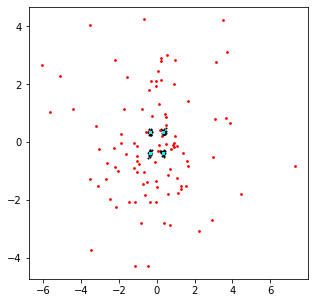

In [20]:
fig = plt.figure(figsize=(5,5))

sigSize = 100
data = np.array([np.random.randint(0,4) for i in range(sigSize)])
# data = np.array([np.random.randint(0,2) for i in range(sigSize)])

symbolPeriod = 1
timeSampling = 0.01
# modulation = 'bpsk'
modulation = 'qpsk'
P = 0.5
t, dataSignal = expandDataToSignal(data, symbolPeriod, timeSampling)

N = 0.1
modulatedSignal = applyModulationOnDataSignal(modulation, dataSignal, P)
noisyModulatedSignal = lambda t, snr: np.array(modulatedSignal(t) + np.array([ 10**(-snr/20) *np.random.randn()*N for i in range(len(t))]), dtype=complex)

# plt.plot(t,modulatedSignal(t))
# plt.plot(t,noisyModulatedSignal(t))
# plt.plot(t,multiPathChannel(modulatedSignal(t), t, 20))

p = makeConstelationSignaling(modulatedSignal(t), symbolPeriod, timeSampling)
pn = makeConstelationSignaling(noisyModulatedSignal(t, -20), symbolPeriod, timeSampling)
pm = makeConstelationSignaling(multiPathChannel(modulatedSignal(t), t, -20), symbolPeriod, timeSampling)

plt.scatter(pn.real, pn.imag , color='black', s=10e-1)
plt.scatter(pm.real, pm.imag, color='red', s=30e-1)
plt.scatter(p.real, p.imag, color='cyan', s=20e-1)

# plt.xlim([-1,1])
# plt.ylim([-1,1])

In [5]:
sigSize = 1e3
# data = np.array([np.random.randint(0,4) for i in range(sigSize)])
data = np.array([np.random.randint(0,2) for i in range(int(sigSize))])

symbolPeriod = 1
timeSampling = 0.01
modulation = 'bpsk'
# modulation = 'qpsk'
P = 0.001
t, dataSignal = expandDataToSignal(data, symbolPeriod, timeSampling)

N = 0.1
modulatedSignal = applyModulationOnDataSignal(modulation, dataSignal, P)
noisyModulatedSignal = lambda t: np.array(modulatedSignal(t) + np.array([np.random.randn()*N for i in range(len(t))]), dtype=complex)


EbN0 = np.linspace(0, 35, 50)
# EbN0 = np.array([-10,0,1,2])

error_awgn = np.zeros(EbN0.shape)
error_fading = np.zeros(EbN0.shape)

for i, k in enumerate(EbN0):
    p = makeConstelationSignaling(modulatedSignal(t), symbolPeriod, timeSampling)
    # pn = makeConstelationSignaling(noisyModulatedSignal(t), symbolPeriod, timeSampling)
    pm = makeConstelationSignaling(multiPathChannel(modulatedSignal(t), t, i), symbolPeriod, timeSampling)

    # receiver hard decision decoding bpsk
    # kk = np.array(np.arctan2(pn.real, pn.imag))
    # yhat_awgn = np.array((kk > 0))

    kk = np.array(np.arctan2(pm.real, pm.imag))
    yhat_fading = np.array((kk > 0))

    d = np.array(data>0)
    # error_awgn[i] = sigSize - np.sum(np.isclose(d, yhat_awgn[0]))
    error_fading[i] = sigSize - np.sum(np.isclose(d, yhat_fading[0]))

    print("\r[%3.2f%%]" % (i * 100. / (50-1)), end="")


[100.00%]

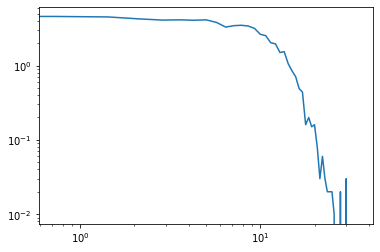

In [22]:
# print(error)
# plt.semilogy(EbN0, error_awgn)
plt.loglog(EbN0, error_fading/sigSize)

In [22]:
data1 = np.genfromtxt('dist/output1000.csv', delimiter=',', skip_header=10, skip_footer=10, names=['snr', 'ber'])
data2 = np.genfromtxt('dist/output10000.csv', delimiter=',', skip_header=10, skip_footer=10, names=['snr', 'ber'])
data3 = np.genfromtxt('dist/output100000.csv', delimiter=',', skip_header=10, skip_footer=10, names=['snr', 'ber']) 

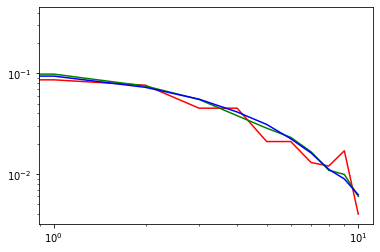

In [23]:
plt.loglog(data1['snr'], data1['ber'], color='r', label='the data')
plt.loglog(data2['snr'], data2['ber'], color='g', label='the data')
plt.loglog(data3['snr'], data3['ber'], color='b', label='the data')